In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

/root/mech-interp-color-steering/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "Qwen/Qwen3-4B"

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"

tokenizer = AutoTokenizer.from_pretrained(model_name, device_map=device)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=device)

print(f"Model loaded on: {model.device}")

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Model loaded on: cuda:0


In [24]:
def chat_batch(batch, max_tokens=32768, temperature=0.7):
	inputs = [
		tokenizer.apply_chat_template(
			messages,
			tokenize=False,
			add_generation_prompt=True,
			enable_thinking=False,
			temperature=temperature
		)

		for messages in batch
	]

	model_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, padding_side="left").to(model.device)

	# conduct text completion
	generated_ids = model.generate(
		**model_inputs,
		max_new_tokens=max_tokens,
	)

	output = []

	for i in range(len(generated_ids)):
		output_ids = generated_ids[i][len(model_inputs.input_ids[i]):].tolist() 

		# parsing thinking content
		try:
			# rindex finding 151668 (</think>)
			index = len(output_ids) - output_ids[::-1].index(151668)
		except ValueError:
			index = 0

		thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
		content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

		output.append({
			"thinking": thinking_content,
			"content": content
		})

	return output



In [18]:
text =  "generate the hex code for a random shade of any color across the color spectrum from light to dark. do not output anything else. it should be a valid hex code starting with #"
messages = [
	{
		"role": "user",
		"content": text
	}
]
batch = [messages for _ in range(500)]

output = chat_batch(batch)

colors = []
for o in output:
	colors.append(o["content"].strip("").upper())

total_colors = len(colors)
unique_colors = len(set(colors))
print("Generated {} colors, {} unique".format(total_colors, unique_colors))

Generated 500 colors, 74 unique


In [19]:
rainbow_colors = {}
for color in colors:
	rainbow_color = utils.get_rainbow_color_name(color)
	if rainbow_color:
		rainbow_colors[rainbow_color] = rainbow_colors.get(rainbow_color, 0) + 1

print(rainbow_colors)

{'Blue': 71, 'Violet': 91, 'Indigo': 329, 'Orange': 8, 'Green': 1}


In [20]:
utils.display_hex_grid(list(colors), columns=20)

/root/mech-interp-color-steering/utils.py:40: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(style_cell)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,#3A70C1,#8F3D8F,#3A70C1,#5E3B8C,#4A2A7C,#4A2A7E,#5E3B8D,#4A2A7E,#8E44AD,#8F3D8F,#4A2A7F,#4A2A7E,#4A2A8E,#4A2A6F,#3E7D9A,#4A2A7E,#4A2A7E,#4A2A7F,#4A2A6F,#4A2A7E
1,#3A6F9A,#4A2A8D,#4A2A7E,#4A2A8E,#8E44AD,#3A70C6,#5E3B8F,#4A2A7E,#4A2A6F,#4A2A8E,#6A3B8E,#4A2A7E,#6A3B8E,#6A3B8F,#4A2A6E,#5E3A7F,#3E7D7E,#4A2A7F,#4A2A7E,#3A70C6
2,#3E7D95,#4A2A7F,#5E3B8F,#4A2A7E,#4A2A8E,#4A2A6E,#6A3B8E,#4A2A6F,#5E3B8C,#4A2A6F,#4A2A7E,#4A2A7F,#4A2A6E,#3E7D9A,#4A2A6F,#4A2A8E,#4A2A7E,#5E3B8C,#4A2A7F,#6A3B8F
3,#5E3B8C,#4A2A7C,#4A2A7E,#4A2A8E,#8B4513,#4A2A7F,#4A2A7F,#6A2E88,#8F3D8F,#4A2A6E,#4A2A7E,#8B3A8B,#4A2A6E,#4A2A6F,#4A2A6E,#8F3D9A,#4A2A6E,#5A2E8B,#4A2A7F,#6A3B8E
4,#5E3B8F,#8E44AD,#3E7D8E,#4A2A7F,#4A2A8E,#4A2A7C,#4A2A7E,#4A2A8E,#4A2A8E,#4A2A7E,#5E3B8C,#4A2A7E,#5E3B8F,#4A2A8E,#4A2A7F,#4A2A7F,#3E72B6,#8F3D8F,#3E72B6,#4A2A7E
5,#3E7D8A,#4A2A7E,#4A2A7F,#3A76B7,#4A2A7C,#3E7D8E,#4A2A8E,#4A2A7E,#4A2A7E,#4A2A7E,#4A2A7F,#4A2A8E,#4A2A7F,#8E44AD,#4A2A7E,#5E3B8C,#3A75B3,#4A2A7E,#4A2A7F,#4A2A7F
6,#4A2A7E,#4A2A6E,#8B4513,#4A2A7E,#4A2A7E,#3A76B5,#5E3B8C,#8F3D9B,#8F3D7A,#4A2A7E,#8E44AD,#4A2A7F,#4A2A6F,#4A2A8E,#5E3B8F,#4A2A6F,#5E3B8E,#4A2A7E,#4A2A7E,#3E7D8A
7,#6A3B8C,#4A2A7E,#3A70C5,#6A3B8E,#8F3D8F,#3A70C1,#4A2A6F,#5E3B8C,#4A2A7F,#6A3D7E,#3A6F9D,#4A2A7E,#8F3D8F,#6A3B8E,#4A2A7E,#4A2A7F,#4A2A85,#8E44AD,#4A2A8E,#4A2A6F
8,#4A2A7F,#4A2A7F,#5A2E8E,#4A2A7F,#4A2A7E,#3E72B6,#8F3D8F,#4A2A6F,#6A3B8E,#4A2A8D,#5E3B8F,#4A2A7E,#3A76B5,#4A2A7E,#3E7D9F,#4A2A6F,#6A3B8E,#4A2A7E,#5E3B8E,#8E44AD
9,#4A2A7F,#5E3B8C,#6A3B8C,#4A2A8E,#4A2A7F,#3A76B6,#3E7D6E,#4A2A6F,#4A2A7F,#4A2A7F,#4A2A8E,#5E3B8C,#8F3D9E,#4A2A6F,#6A3B8F,#4A2A7E,#3E72A6,#4A2A6F,#6A3B8C,#4A2A8E


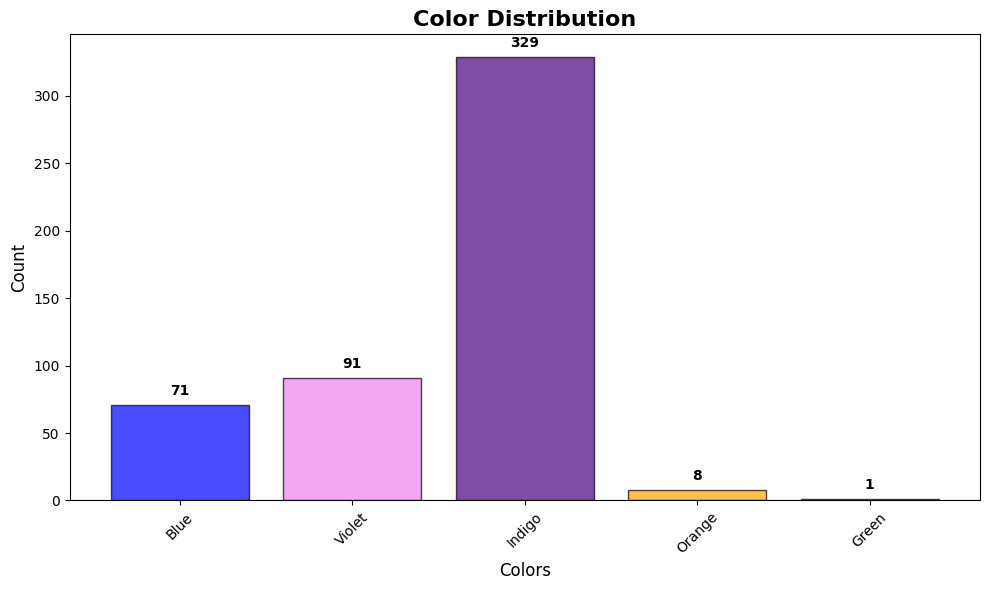

In [21]:
utils.plot_color_distribution(rainbow_colors)

In [22]:
dataset_without_colors = pd.read_csv("data/dataset_without_colors_in_prompt_with_annotated_colors.csv")

In [67]:
for row in dataset_without_colors["prompt"]:
	print(row)


Generate a website for a law firm specializing in family law.
Create a website for a small accounting firm serving local businesses.
Design a landing page for a freelance software engineer.
Build a corporate website for a management consulting company.
Generate a portfolio site for an independent graphic designer.
Create a website for an online tutoring service.
Generate a platform for a local language school.
Build a university department homepage.
Make a site for an educational nonprofit organization.
Design an interactive site for a children’s learning center.
Generate a website for a dental clinic.
Build a homepage for a physiotherapy practice.
Create a website for a mental health counseling center.
Make a site for a veterinary clinic.
Develop a telemedicine platform landing page.
Create an online store for handmade jewelry.
Build a site for a boutique clothing brand.
Generate a product page for a consumer electronics company.
Make a website for a subscription box service.
Design a

In [56]:
SYSTEM_PROMPT =  """
You are an expert website designer and software engineer.

You will be given a request to generate a website or software.

You need to produce a single HTML file that can be used as a website.
Rules to follow:
- The output should only be the HTML code. No other text or comments. No code blocks like ```html.
- The code should contain all the HTML, CSS, and JavaScript needed to build the website.
- Only use valid hex codes for colors.
- The website should be colorful and modern. Choose a beautiful color for the brand.
"""

def get_messages(prompt):
	return [
		{
			"role": "system",
			"content": SYSTEM_PROMPT
		},
		{
			"role": "user",
			"content": prompt
		}
	]

outputs = []
inputs = [get_messages(prompt) for prompt in dataset_without_colors['prompt']]

BATCH_SIZE = 10
for i in range(0, len(inputs), BATCH_SIZE):
	batch = inputs[i:i+BATCH_SIZE]
	output = chat_batch(batch)
	outputs.extend(output)



In [57]:
len(outputs)

50

In [58]:
import re

def extract_hex_codes(text):
	"""
	Extracts hex codes (3 or 6 characters) from a text, including the '#' prefix.
	"""
	return re.findall(r'(#[A-Fa-f0-9]{6}|#[A-Fa-f0-9]{3})', text)


In [59]:

import webcolors
import colorsys

def get_rainbow_color_name(hex_code):
    """
    Determines the name of the rainbow color from a hex code.

    Args:
        hex_code (str): The hex code, e.g., '#FF0000'.

    Returns:
        str: The name of the nearest rainbow color, or None if the input is invalid.
    """
    try:
        # Convert hex to RGB tuple
        rgb_tuple = webcolors.hex_to_rgb(hex_code)
    except ValueError:
        return None

    # Convert RGB to HSL. Note: colorsys returns (hue, lightness, saturation).
    r, g, b = [c / 255.0 for c in rgb_tuple]
    h, l, s = colorsys.rgb_to_hls(r, g, b)

    # --- FIX: Check for desaturated colors (black, white, gray) first. ---
    # The hue of a desaturated color is meaningless, so we handle these separately.
    if s < 0.1:  # Low saturation indicates a shade of gray
        if l > 0.9:
            return "White"
        elif l < 0.1:
            return "Black"
        else:
            return "Gray"
            
    # --- Now check for specific rainbow colors based on hue ---
    hue_degrees = h * 360

    if 330 <= hue_degrees or hue_degrees < 15:
        return "Red"
    elif 15 <= hue_degrees < 45:
        return "Orange"
    elif 45 <= hue_degrees < 75:
        return "Yellow"
    elif 75 <= hue_degrees < 165:
        return "Green"
    elif 165 <= hue_degrees < 255:
        return "Blue"
    elif 255 <= hue_degrees < 270:
        return "Indigo"
    elif 270 <= hue_degrees < 330:
        return "Violet"

    return None

print(get_rainbow_color_name("#fff"))

def get_rainbow_color_frequency(colors):
	rainbow_colors = {}
	for color in colors:
		rainbow_color = get_rainbow_color_name(color)
		if rainbow_color:
			rainbow_colors[rainbow_color] = rainbow_colors.get(rainbow_color, 0) + 1
	return rainbow_colors

White


/root/mech-interp-color-steering/utils.py:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


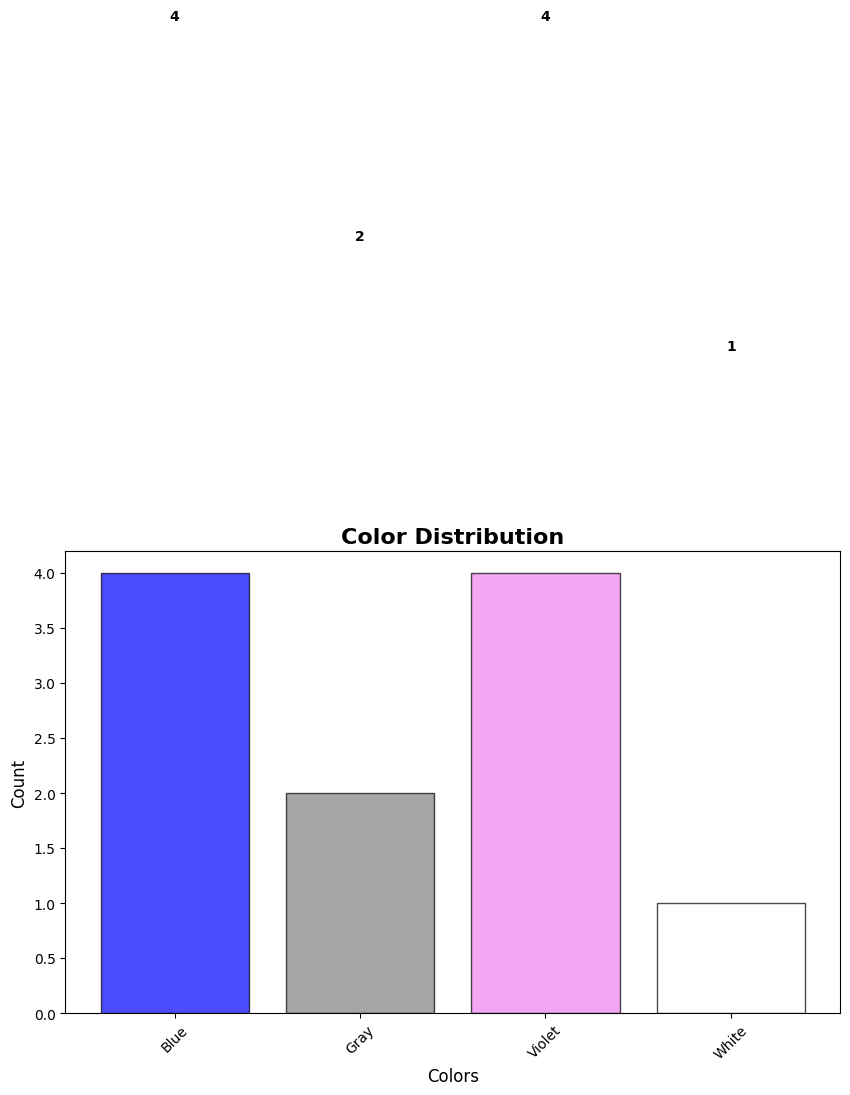

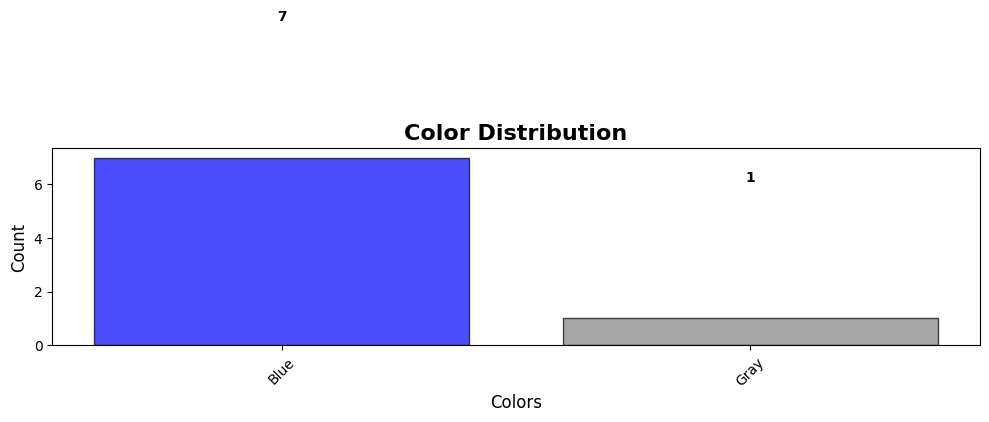

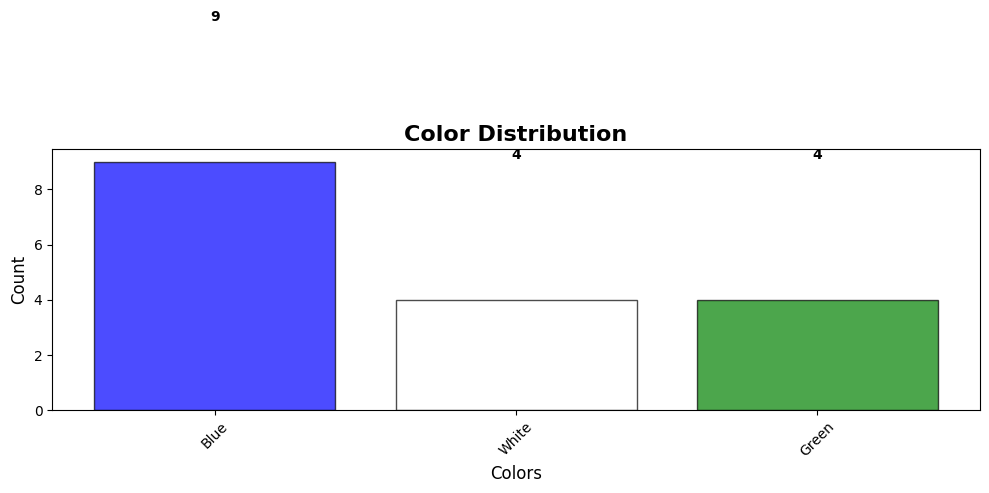

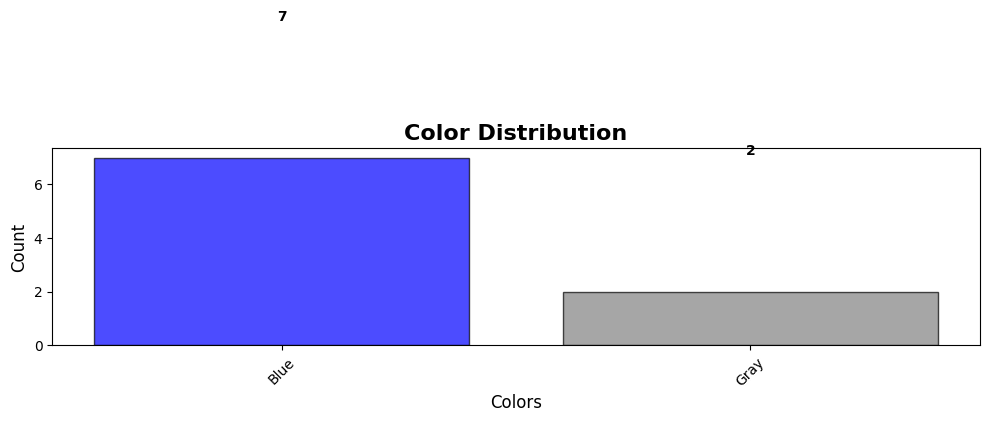

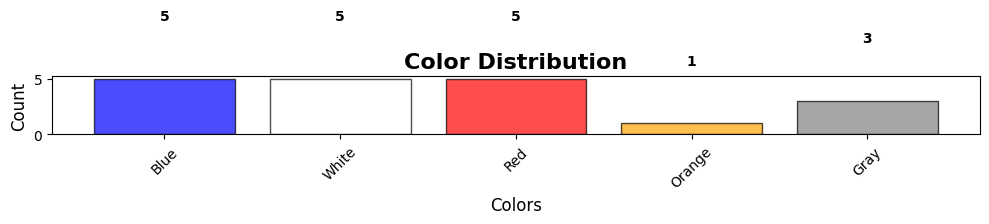

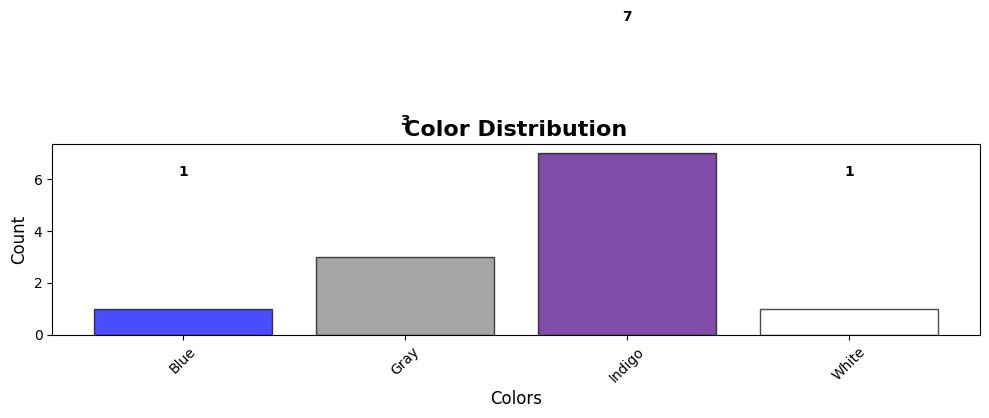

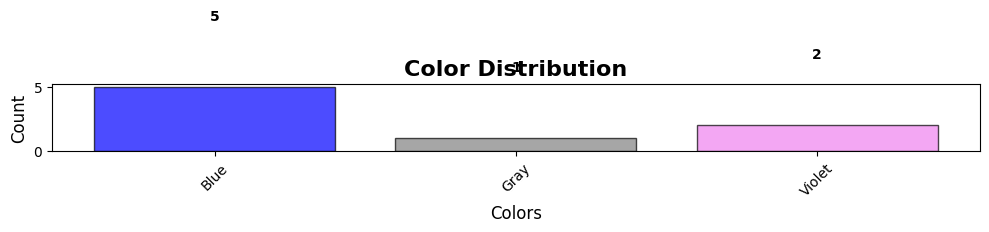

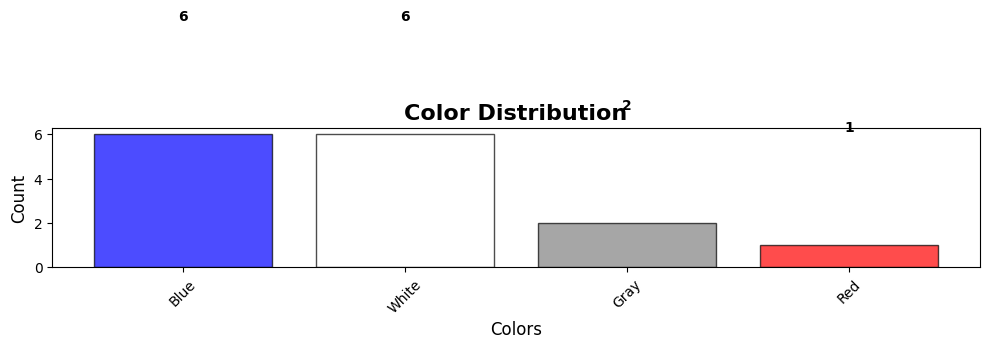

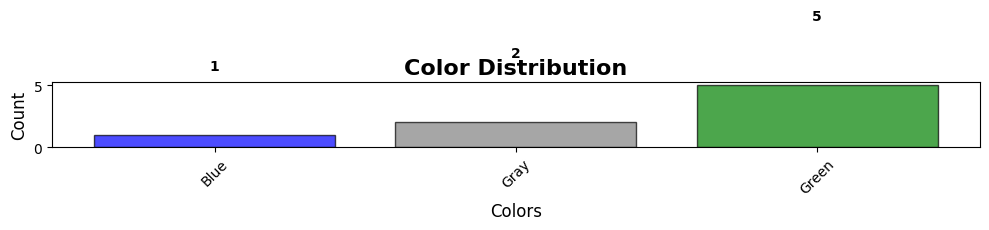

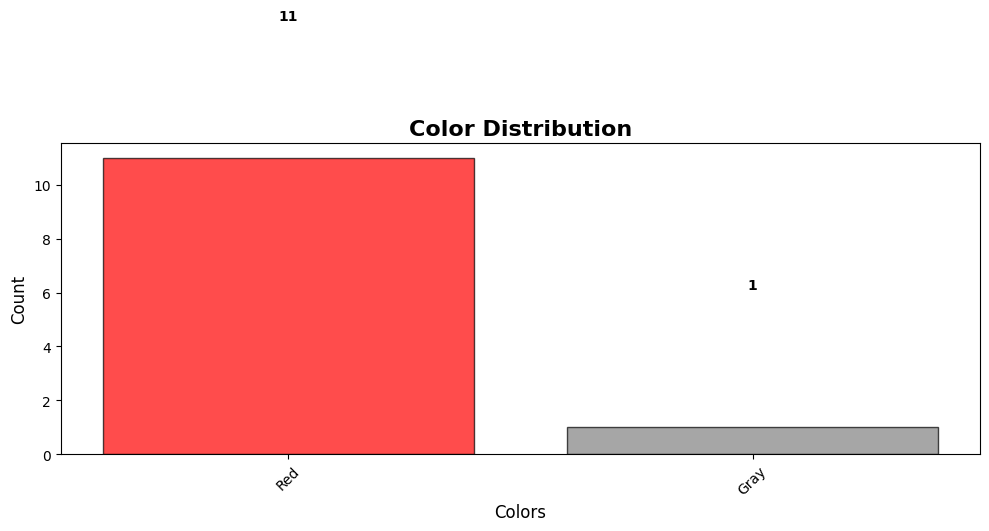

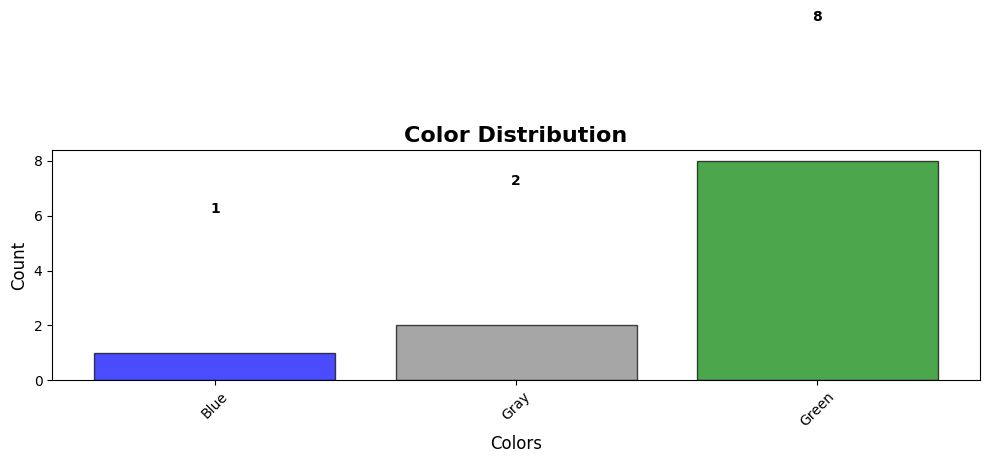

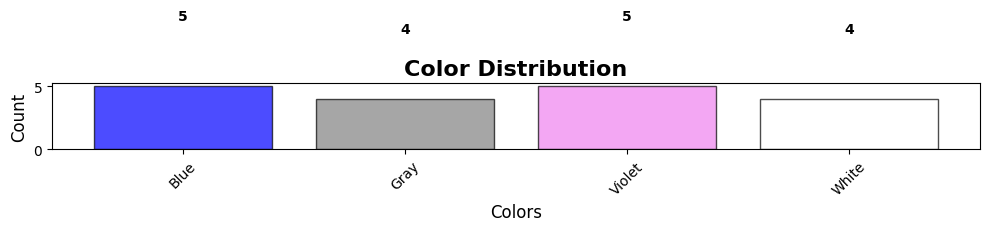

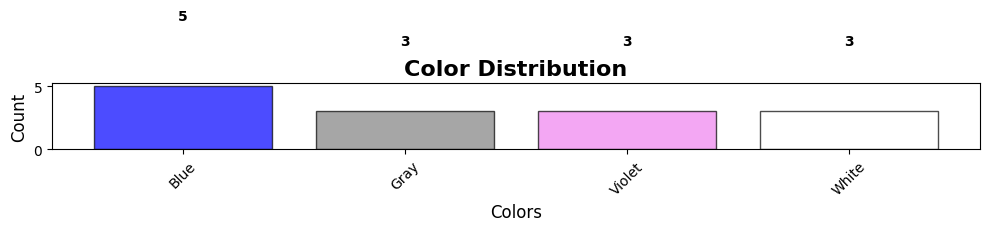

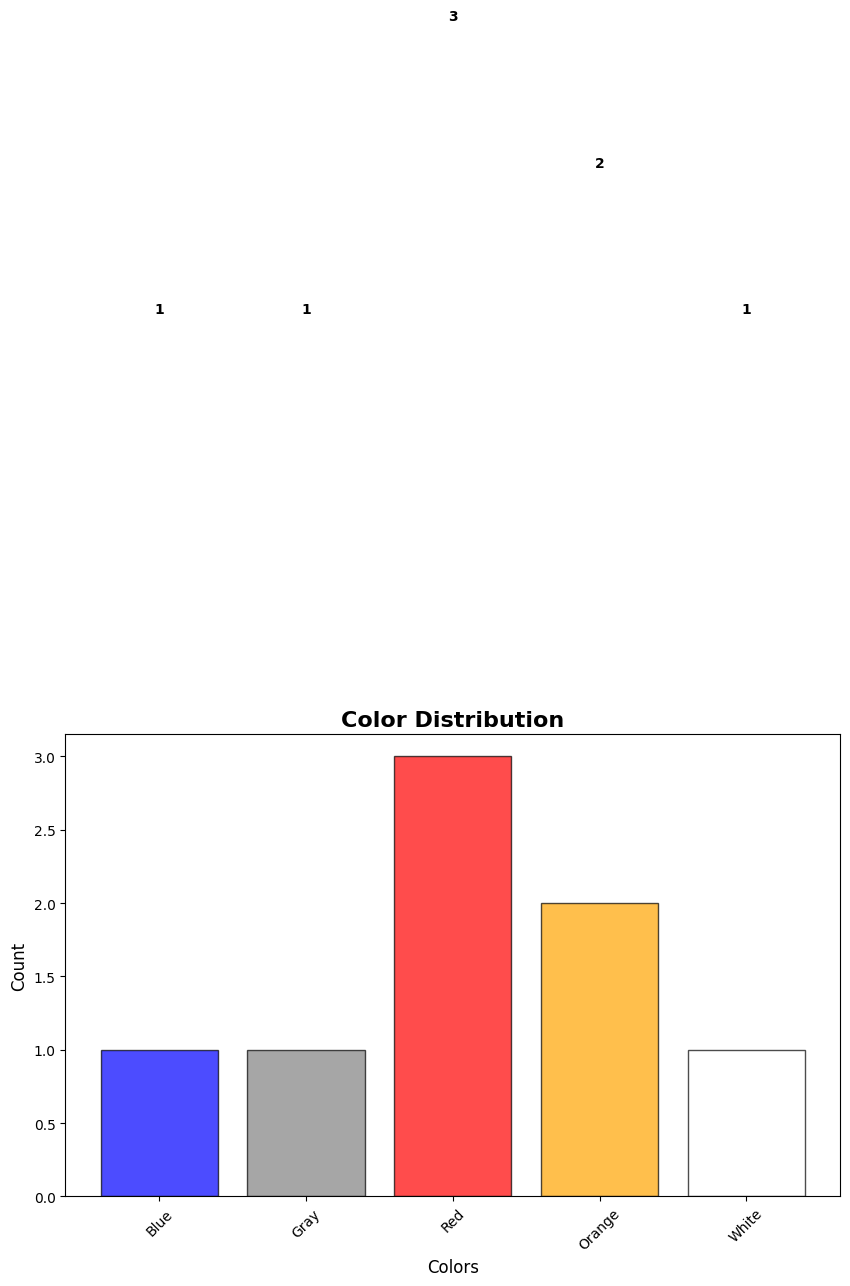

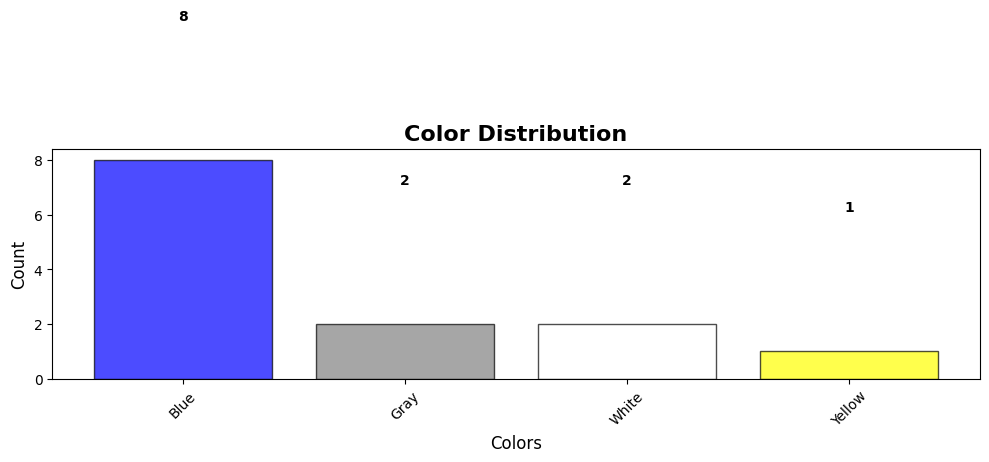

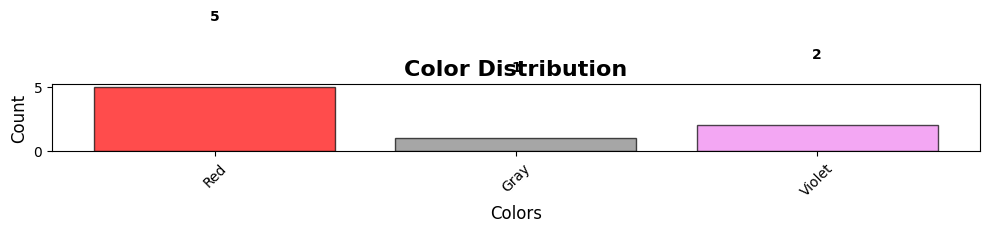

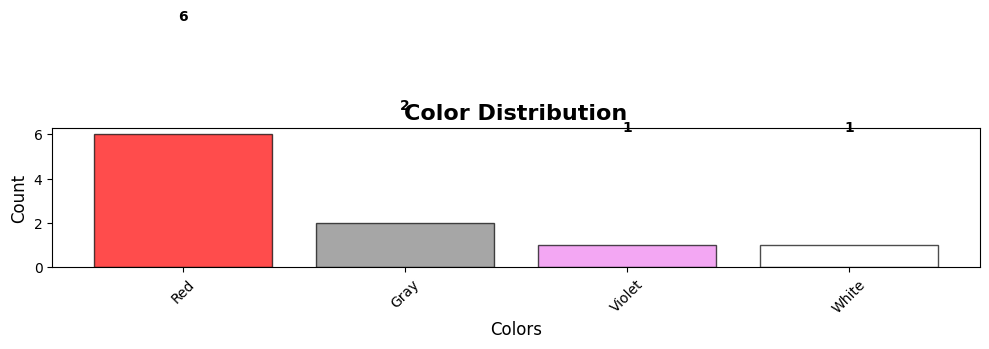

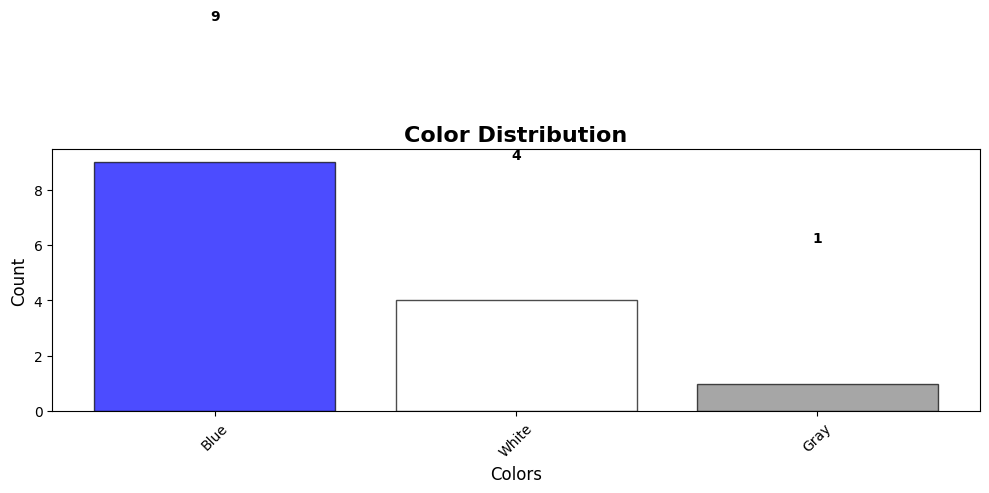

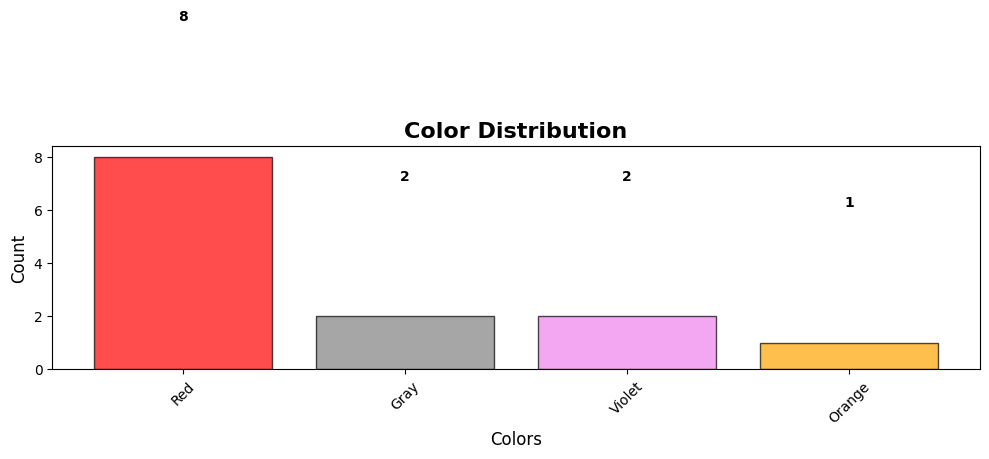

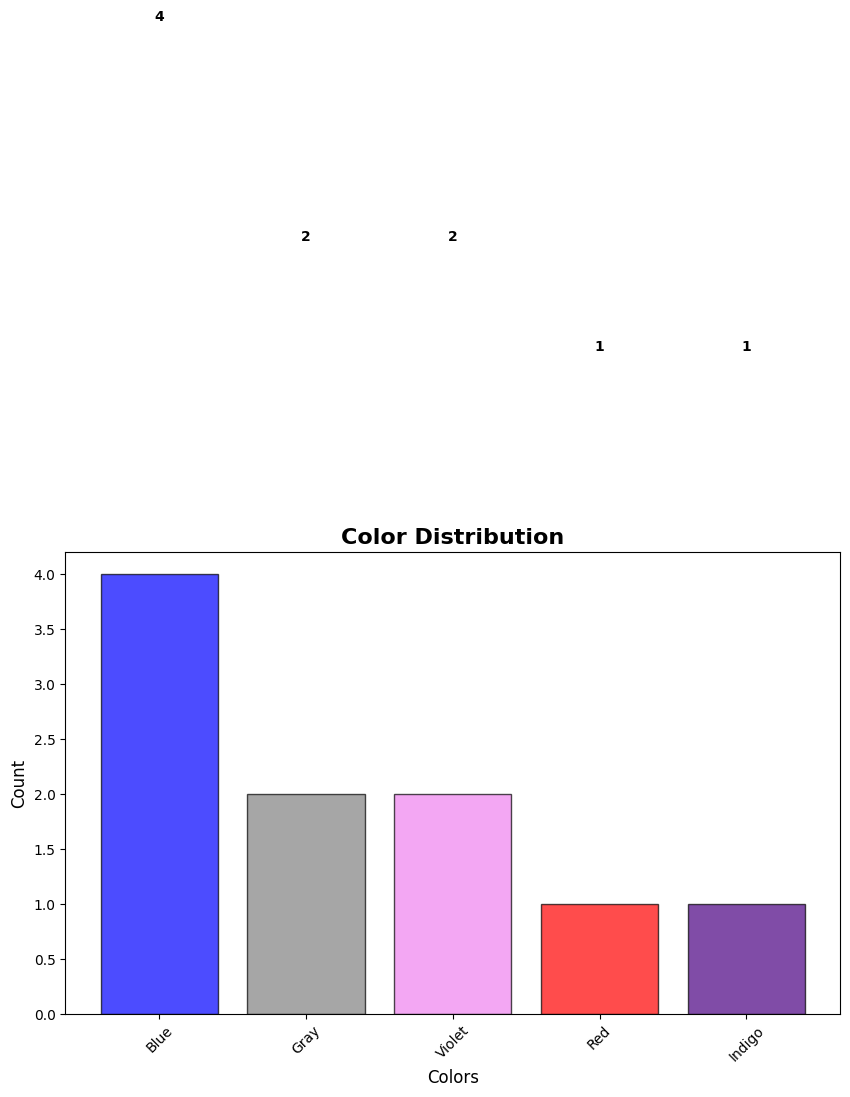

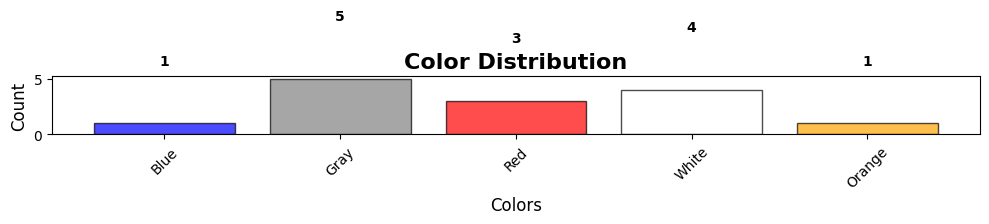

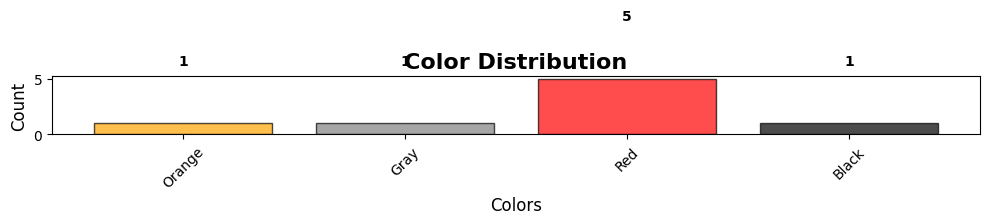

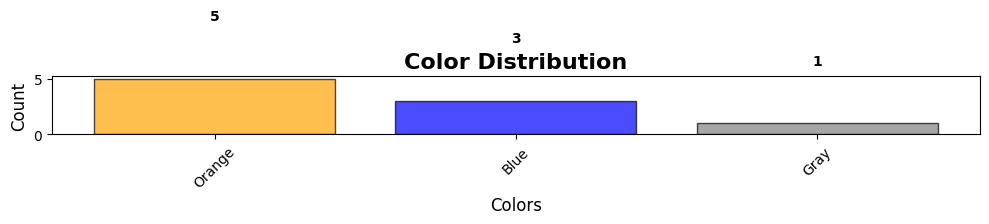

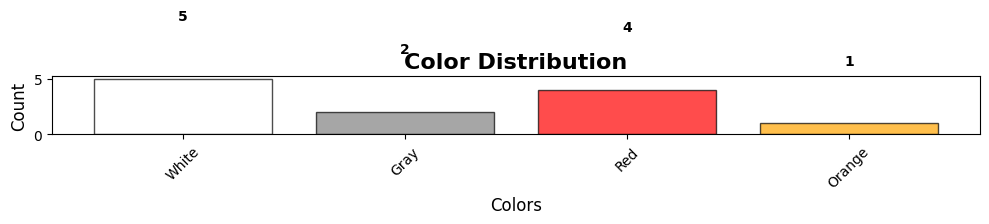

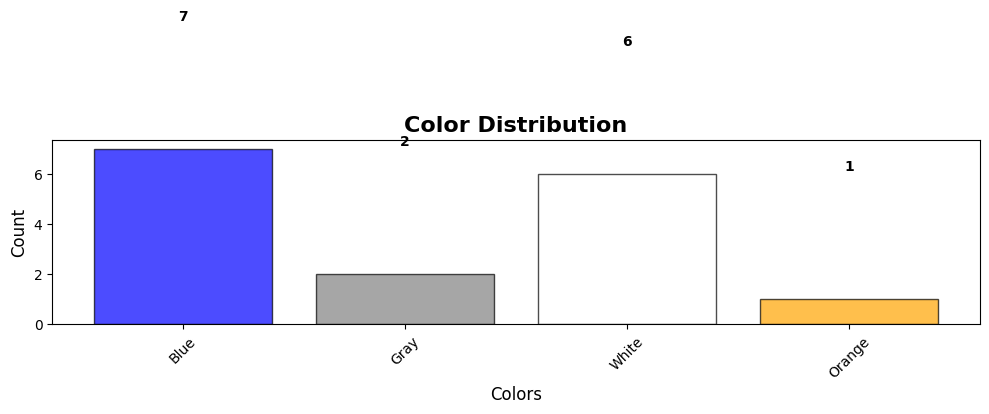

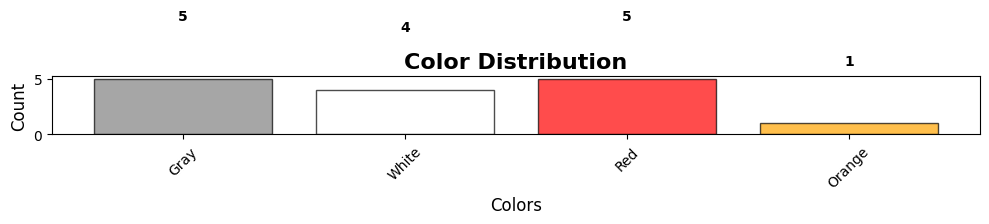

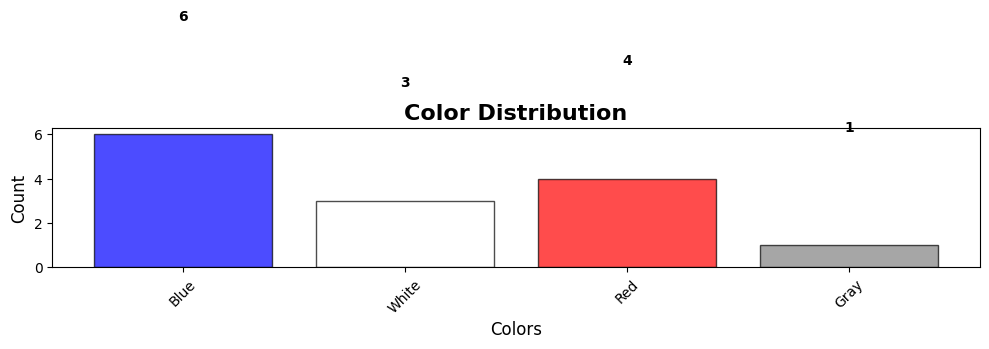

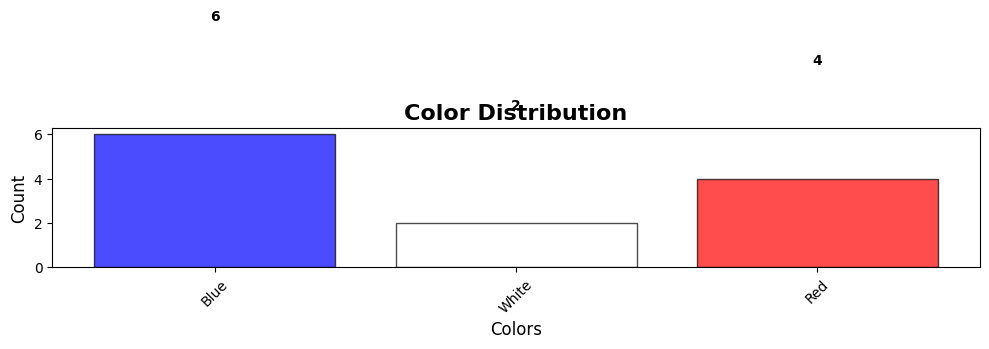

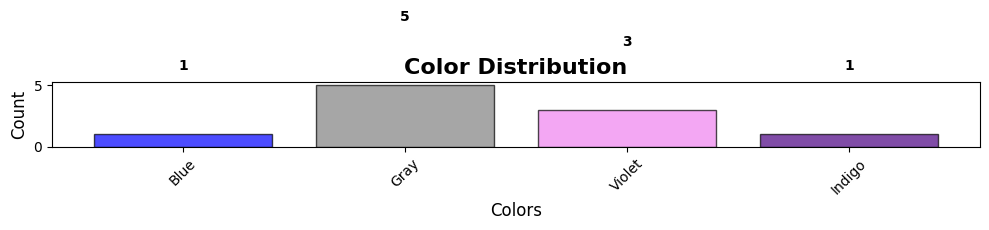

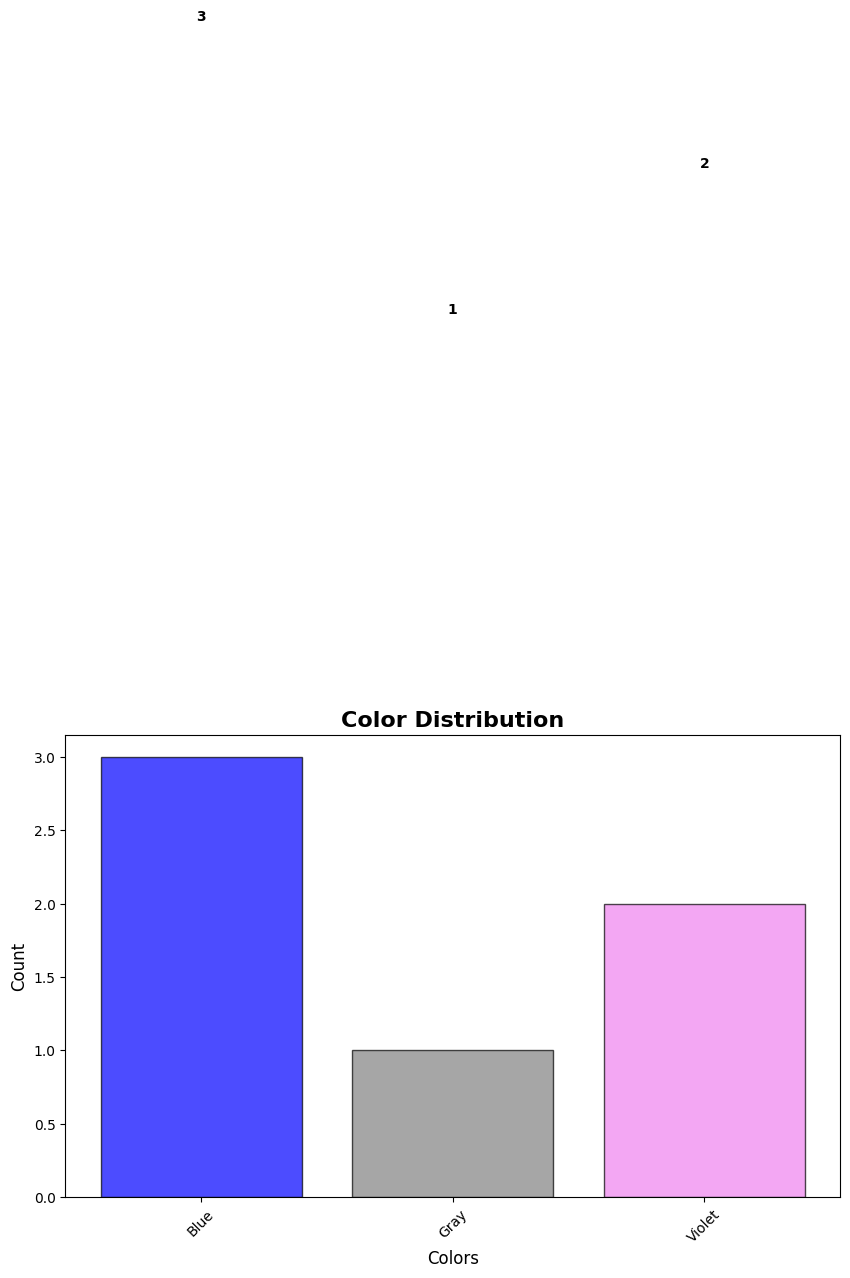

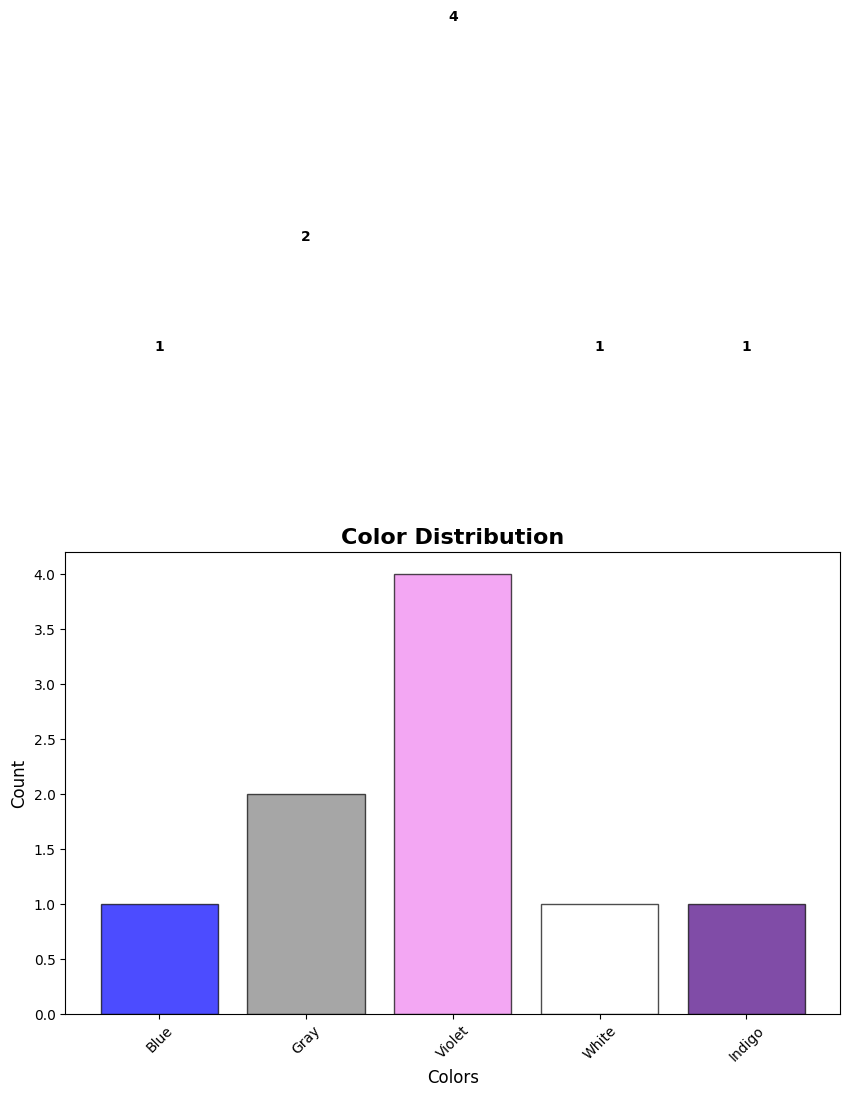

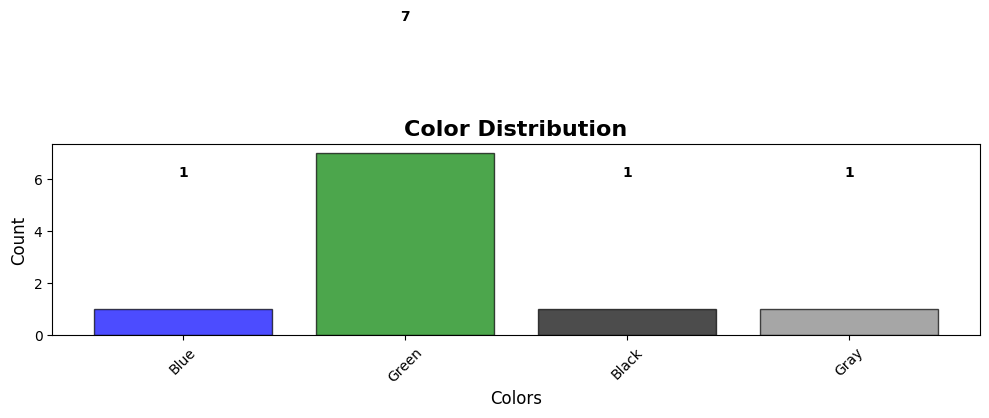

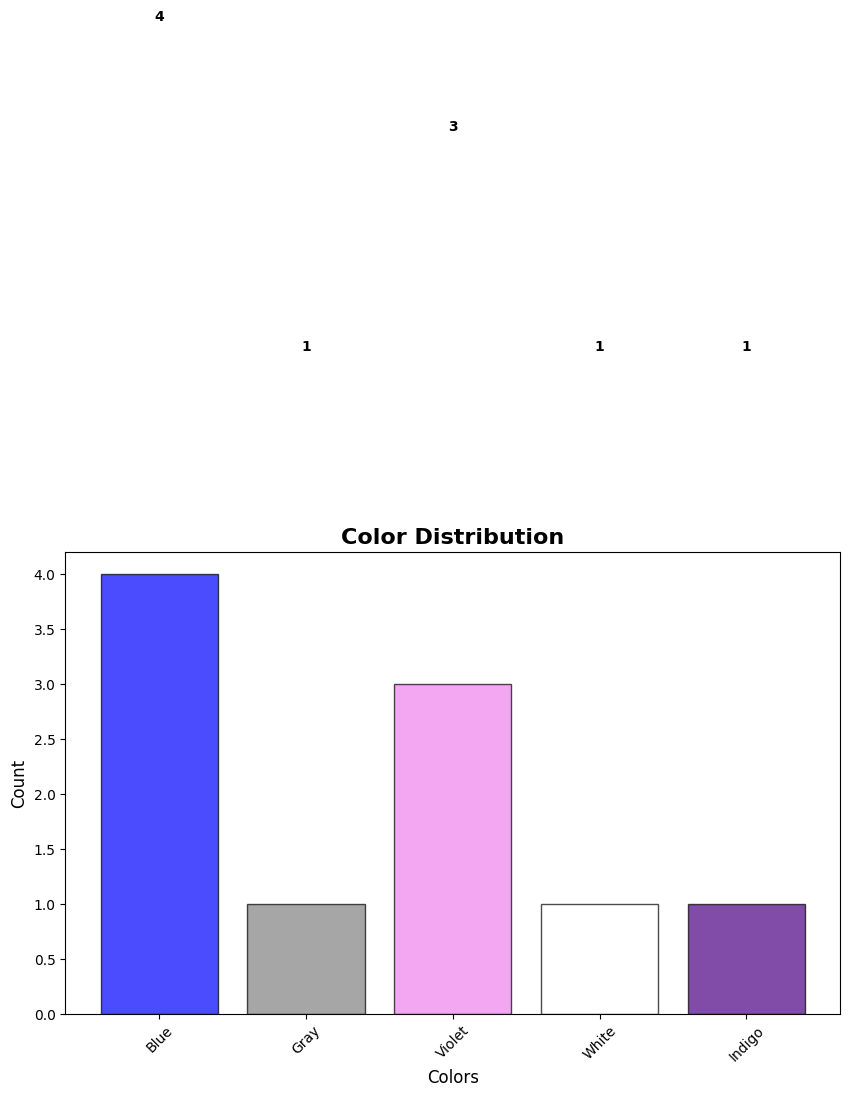

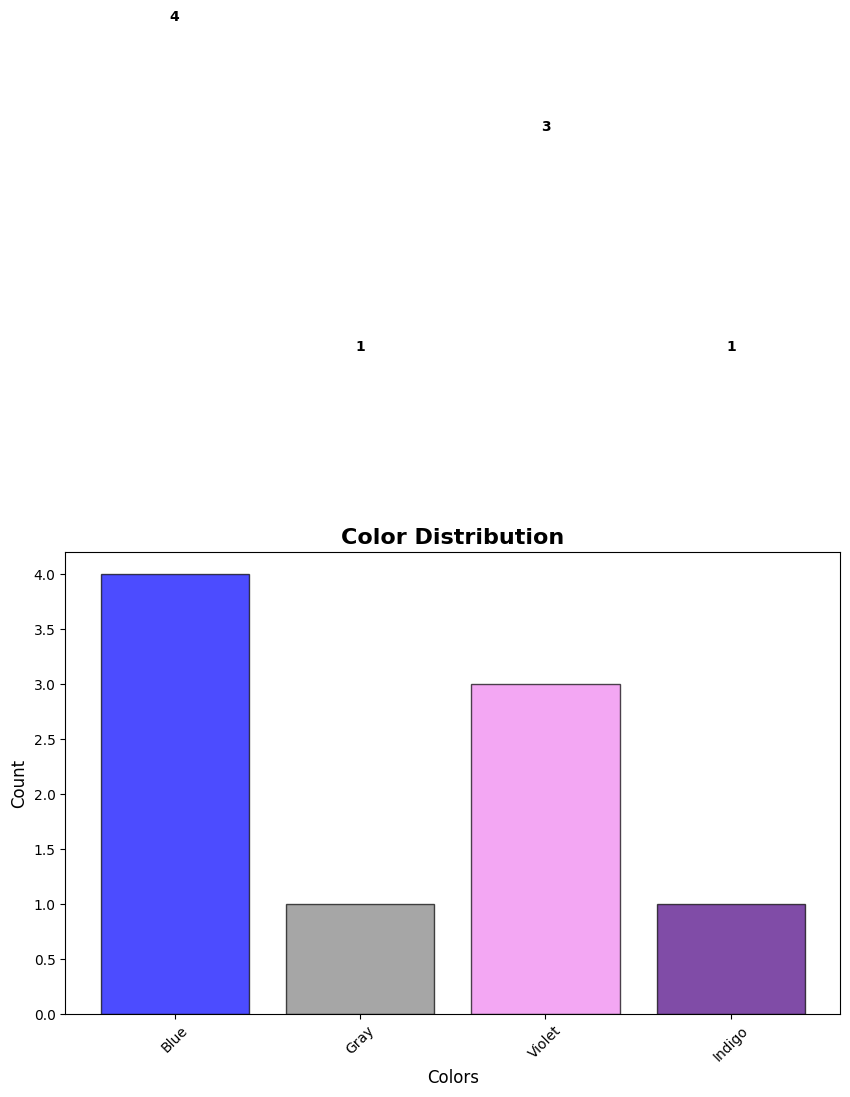

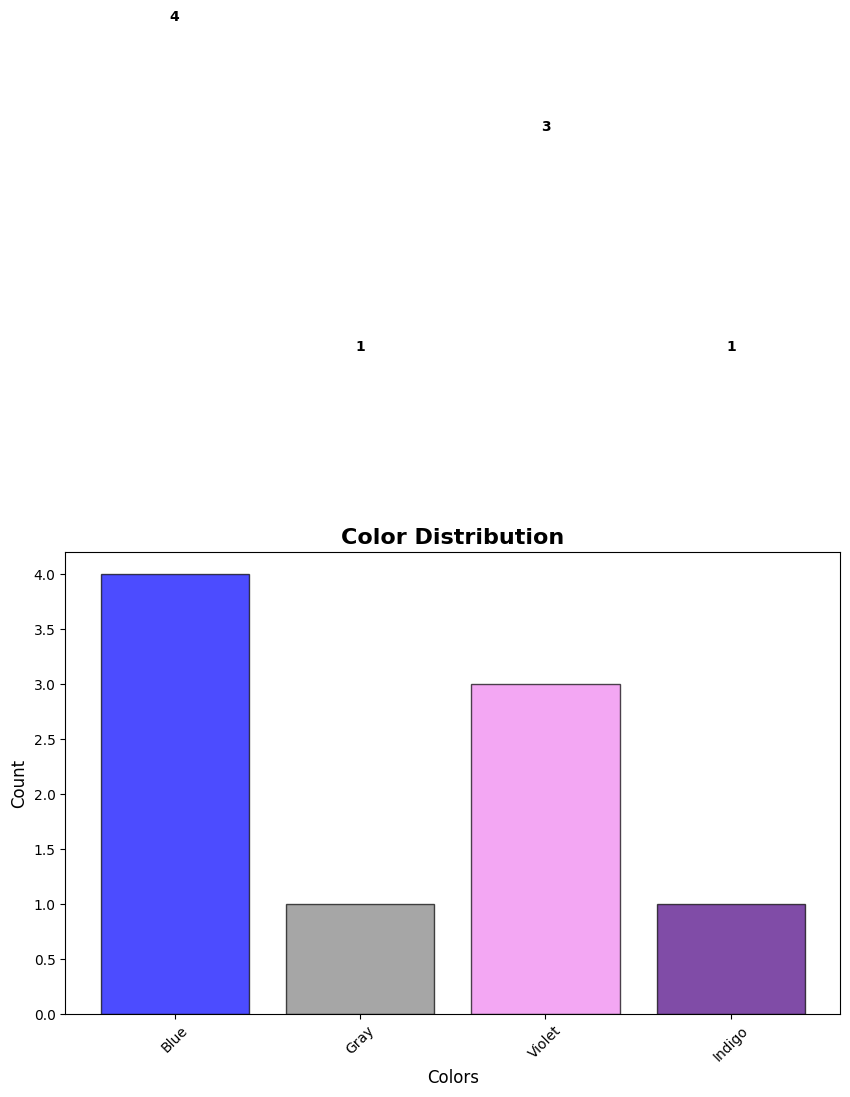

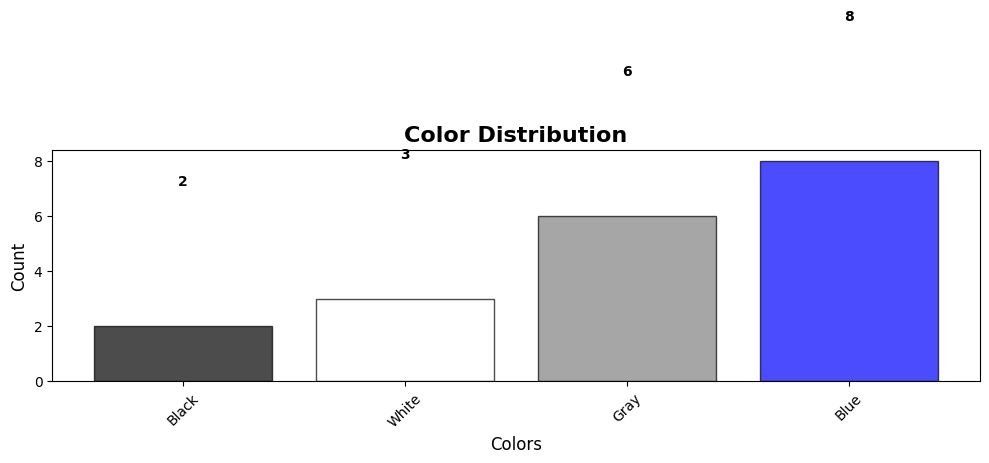

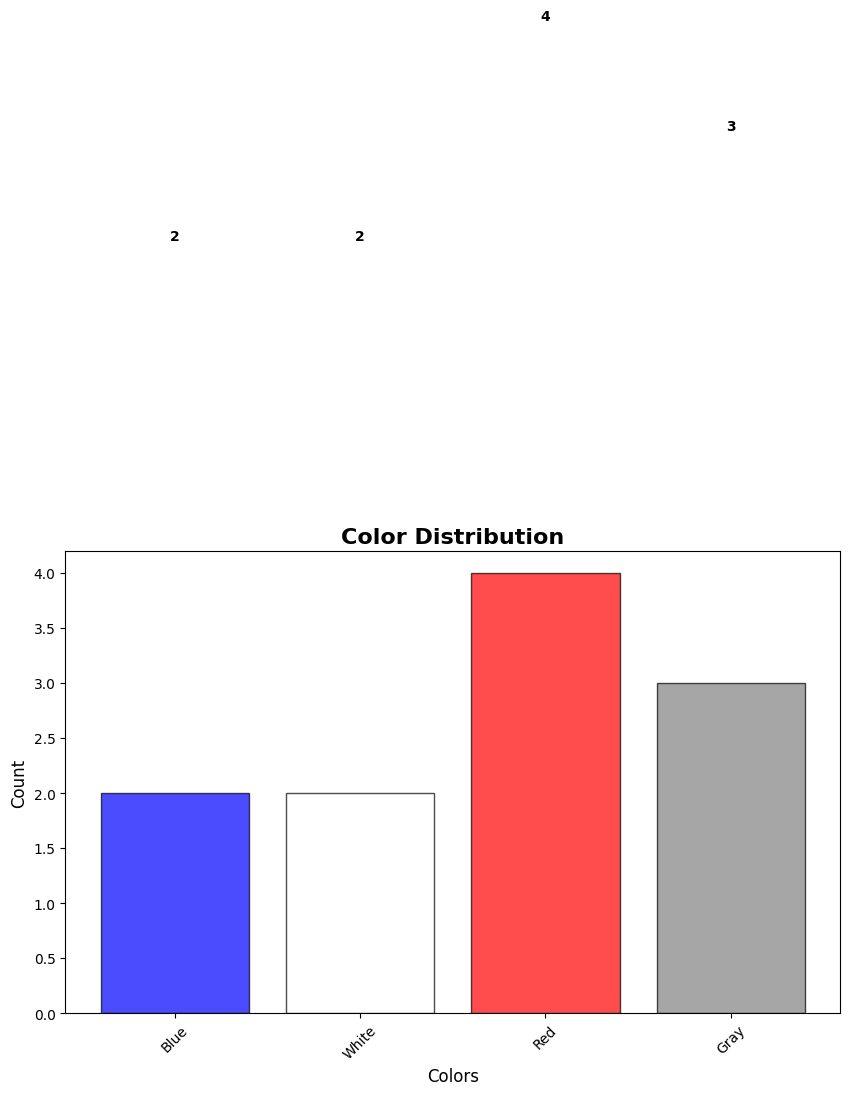

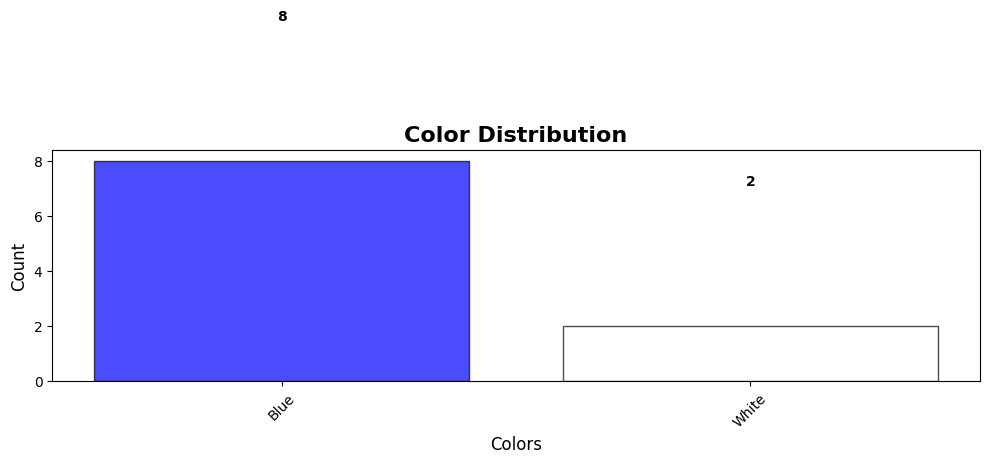

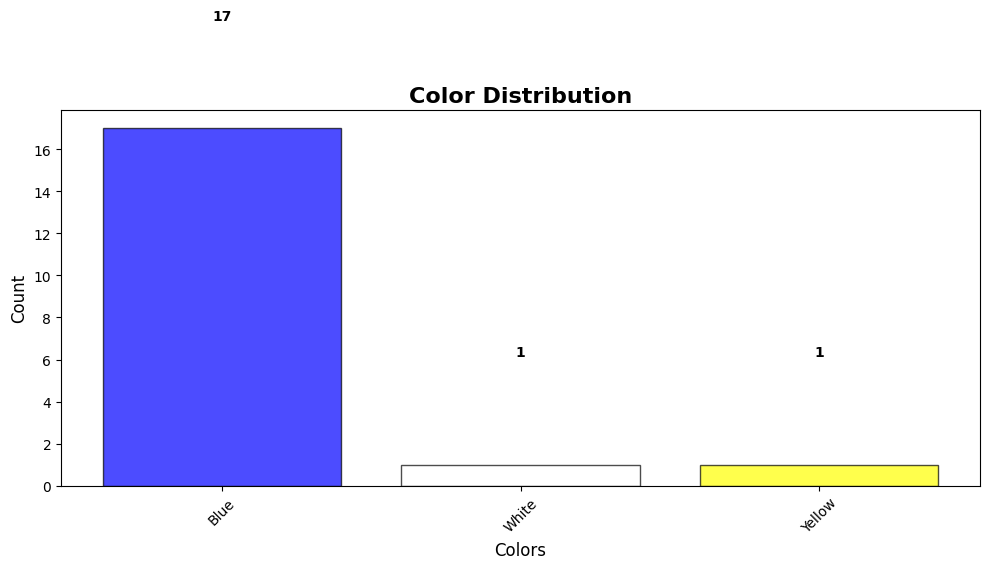

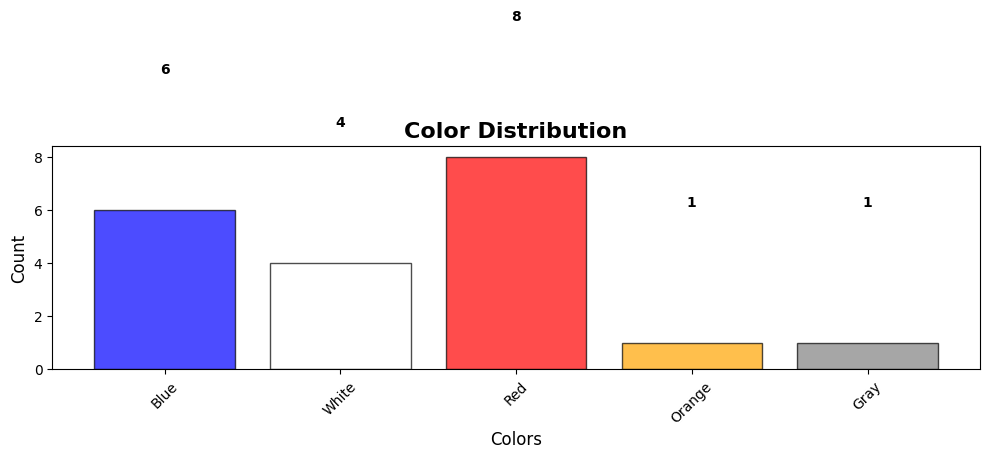

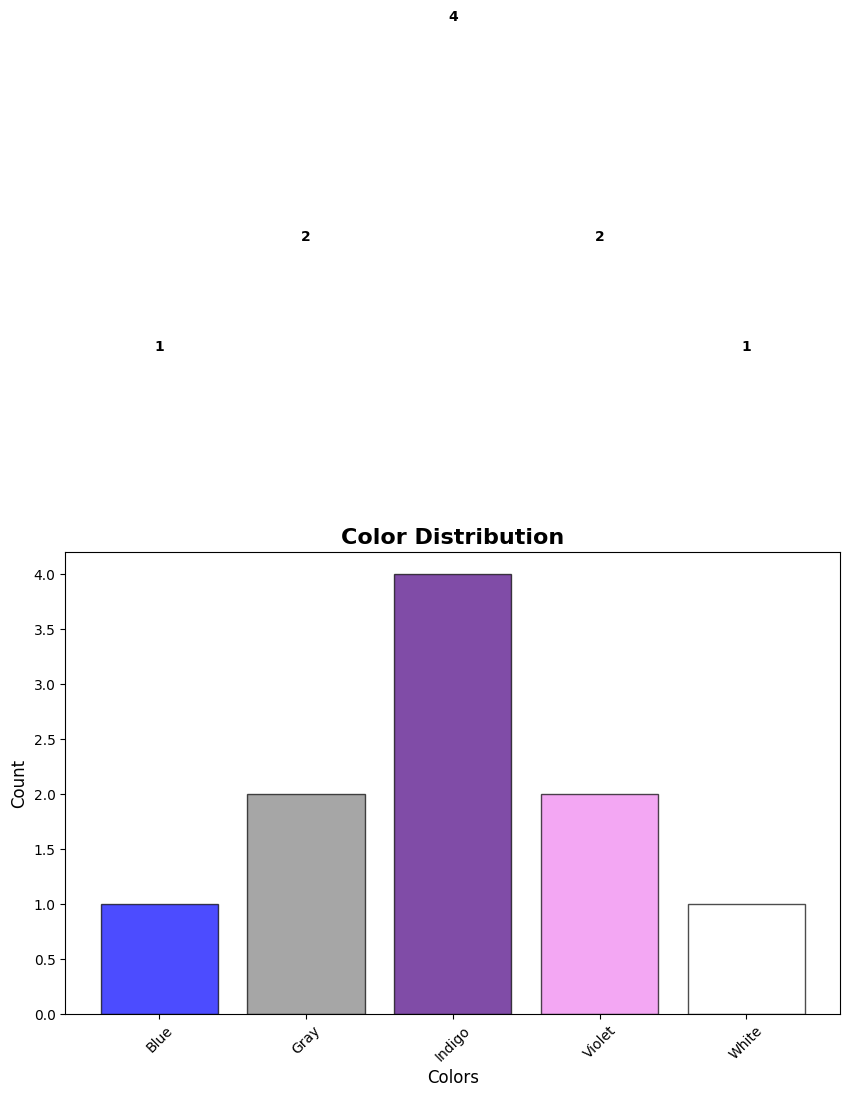

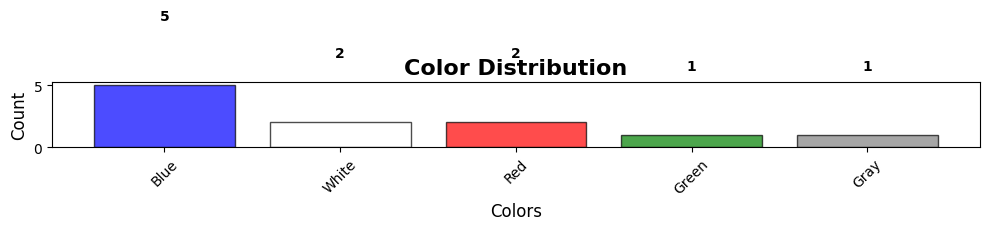

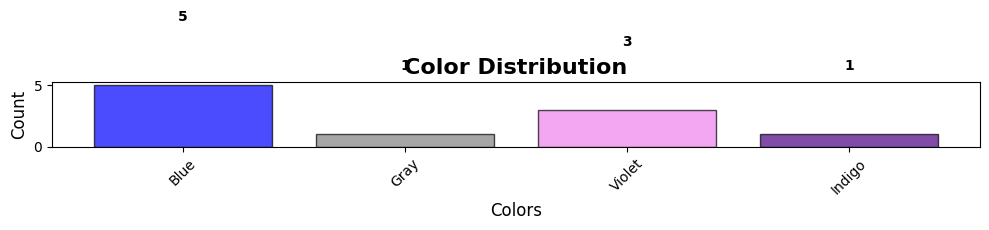

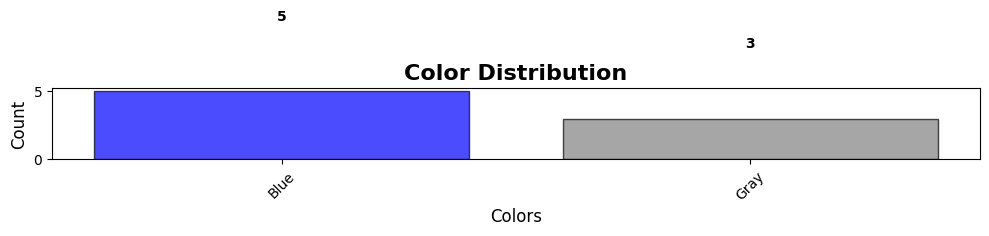

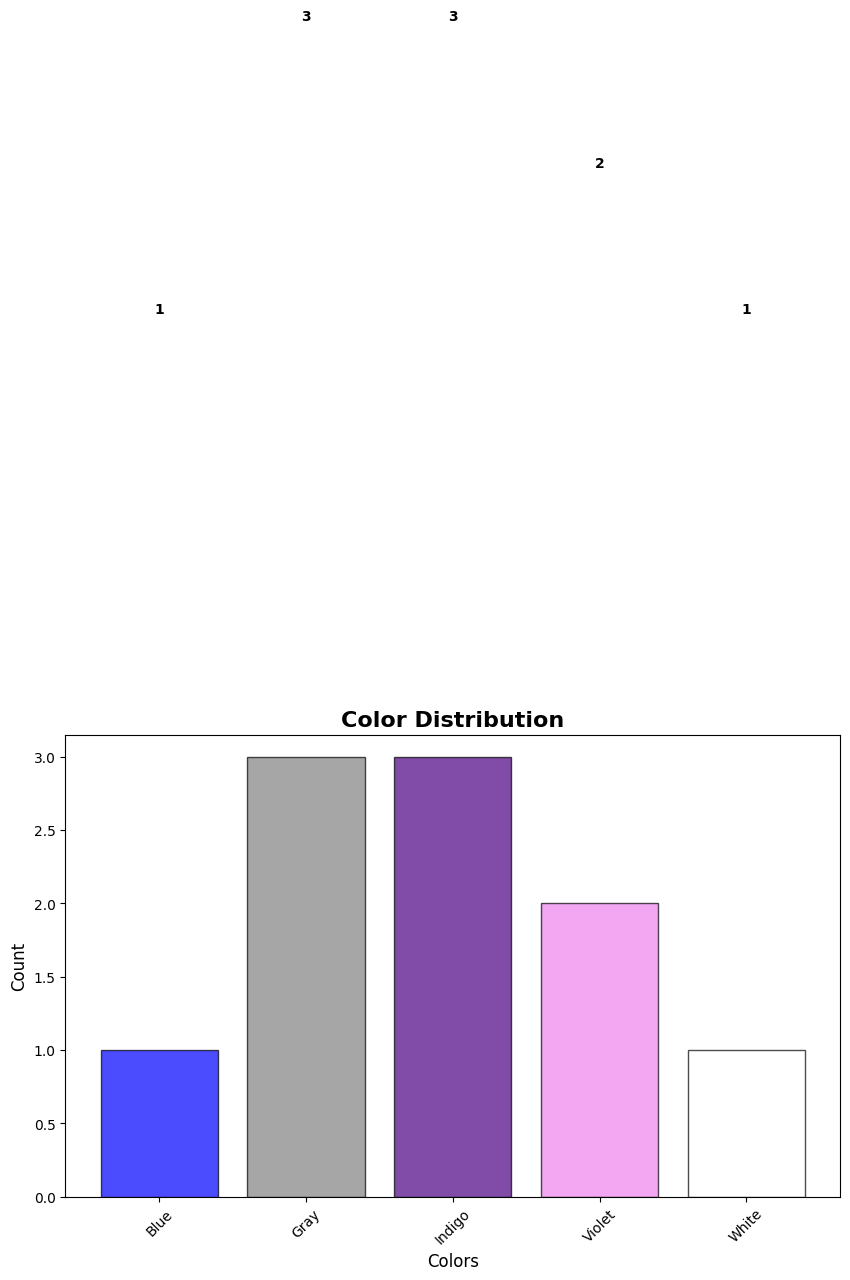

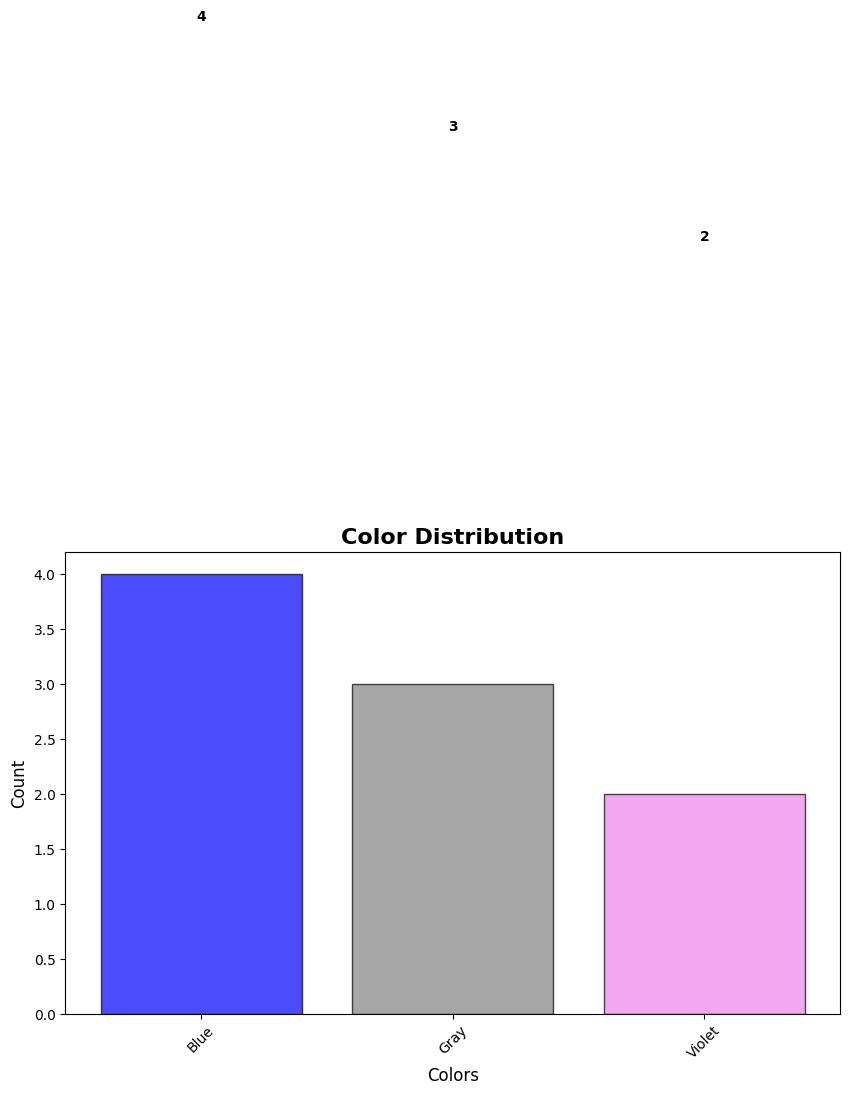

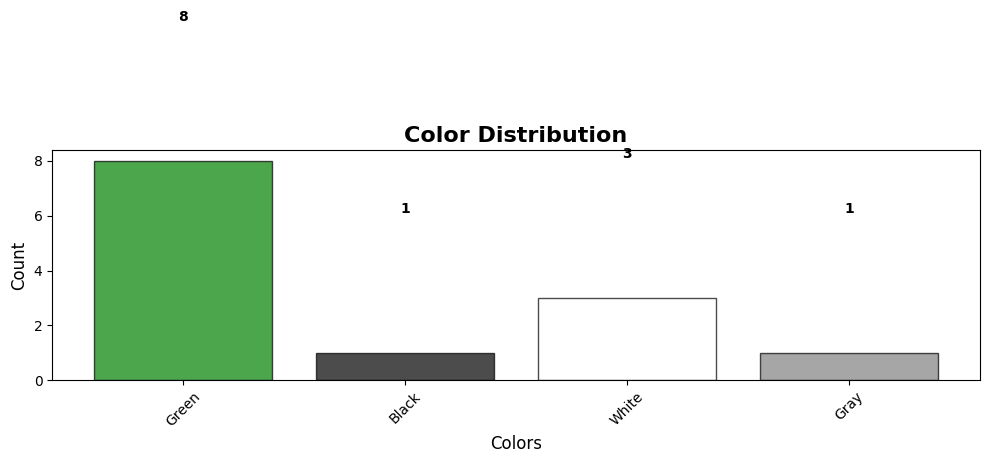

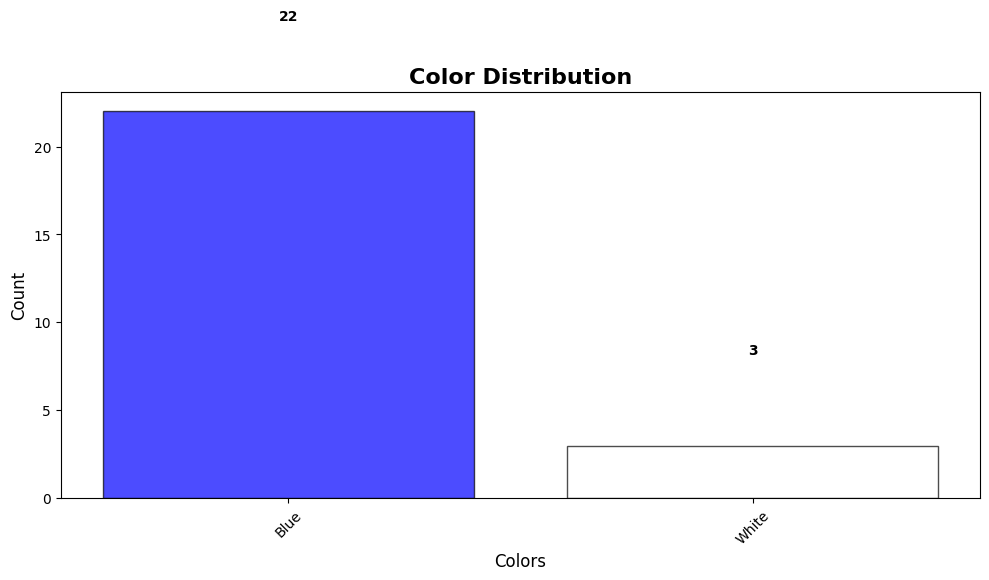

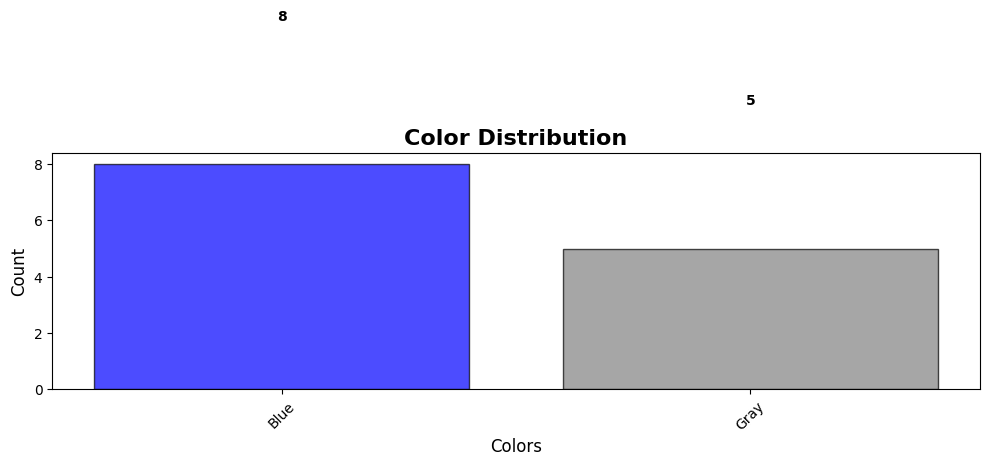

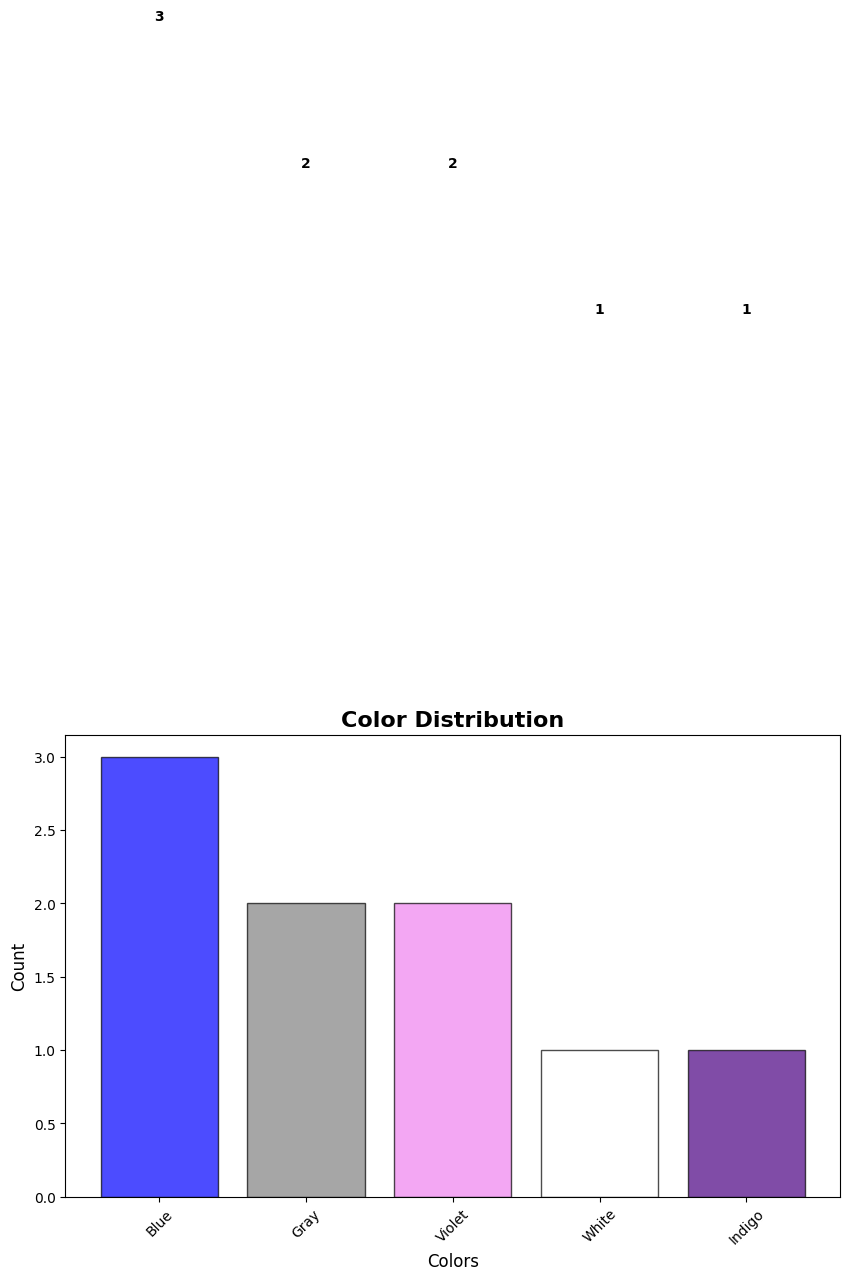

In [60]:
code_colors = []
for o in outputs:
	code_colors.append(extract_hex_codes(o['content']))
	# print(code_colors[-1])

for c in code_colors:
	color_distribution = get_rainbow_color_frequency(c)
	utils.plot_color_distribution(color_distribution)
	# print(color_distribution)

In [61]:
# save the outputs in html files
for i, o in enumerate(outputs):
	with open(f"outputs/output_{i}.html", "w") as f:
		f.write(o['content'])


In [64]:
overall_color_distribution = {}

for c in code_colors:
	color_distribution = get_rainbow_color_frequency(c)
	for color, count in color_distribution.items():
		overall_color_distribution[color] = overall_color_distribution.get(color, 0) + count

print(overall_color_distribution)

{'Blue': 214, 'Gray': 97, 'Violet': 50, 'White': 81, 'Green': 33, 'Red': 79, 'Orange': 15, 'Indigo': 22, 'Yellow': 2, 'Black': 5}


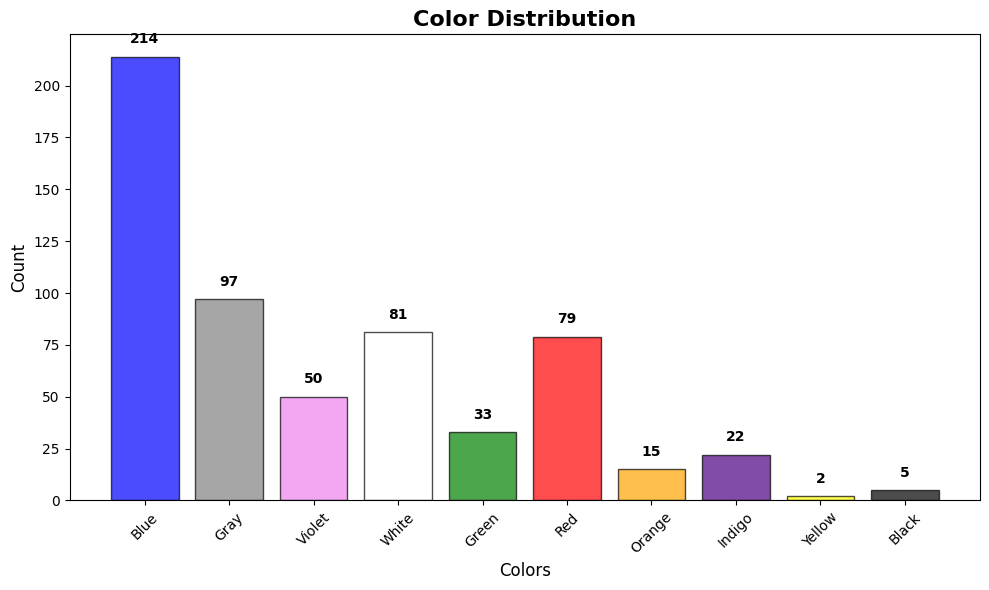

In [65]:
utils.plot_color_distribution(overall_color_distribution)